# Multi step model (simple encoder-decoder)

In this notebook, we will demonstrate how to implement a RNN model to predict multiple time steps into the future using a simple encoder decoder approach.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [2]:
%run -i load_data.py
%run -i mape.py
%run -i TimeSeriesTensor.py
%run -i create_evaluation_df.py

In [3]:
if not os.path.exists(os.path.join('data', 'energy.csv')):
    %run extract_data.py
energy = load_data()
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [4]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

T = 6
HORIZON = 3

Create training set containing only the model features

In [5]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [6]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Create input tensors

In [7]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, {'X':(range(-T+1, 1), ['load', 'temp'])})

In [8]:
train_inputs.shifted_df.head()

tensor              target              X                                     \
feature                  y           load                          temp        
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4   
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43   
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40   
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41   
2012-01-01 08:00:00   0.35 0.37 0.37 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42   
2012-01-01 09:00:00   0.37 0.37 0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41   

tensor                                   
feature                                  
time step            t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.40 0.41 0.42 0.41  
2012-01-01 06:00:00 0.41 0.42 0.41 0.40  
2012-01-01 07:00:00 0.42 0.41 0.40 0.39  
2012-01-01 08:00:00 0.41 0.40 0.39 0.39  
2012-01-01 09:00:00 0.40 0.39 0.39 0.43

Construct validation set (keeping W hours from the training set in order to construct initial features)

In [9]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement the RNN

In [10]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [11]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 100

In [12]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(RepeatVector(HORIZON))
model.add(GRU(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [13]:
model.compile(optimizer='RMSprop', loss='mse')

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 5)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 3, 5)              165       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 1)              6         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [15]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [16]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

Train on 23368 samples, validate on 1461 samples
Epoch 1/100
23368/23368 [==============================] - 5s 208us/step - loss: 0.0221 - val_loss: 0.0065
Epoch 2/100
23368/23368 [==============================] - 5s 198us/step - loss: 0.0050 - val_loss: 0.0044
Epoch 3/100
23368/23368 [==============================] - 5s 203us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/100
23368/23368 [==============================] - 5s 205us/step - loss: 0.0037 - val_loss: 0.0048
Epoch 5/100
23368/23368 [==============================] - 4s 185us/step - loss: 0.0035 - val_loss: 0.0037
Epoch 6/100
23368/23368 [==============================] - 5s 204us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 7/100
23368/23368 [==============================] - 5s 204us/step - loss: 0.0033 - val_loss: 0.0045
Epoch 8/100
23368/23368 [==============================] - 5s 195us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/100
23368/23368 [==============================] - 4s 189us/step - loss: 0.0033 - val_l

## Evaluate the model

In [17]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [18]:
predictions = model.predict(test_inputs['X'])

In [19]:
predictions

array([[ 0.24,  0.31,  0.38],
       [ 0.32,  0.4 ,  0.46],
       [ 0.39,  0.46,  0.51],
       ..., 
       [ 0.63,  0.56,  0.51],
       [ 0.58,  0.52,  0.47],
       [ 0.54,  0.5 ,  0.45]], dtype=float32)

In [20]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,749.33","2,714.00"
1,2014-11-01 06:00:00,t+1,"3,008.29","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,250.88","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,382.39","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,494.47","3,436.00"


In [21]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
t+2   0.04
t+3   0.06
Name: APE, dtype: float64

In [22]:
mape(eval_df['prediction'], eval_df['actual'])

0.04203959338090348

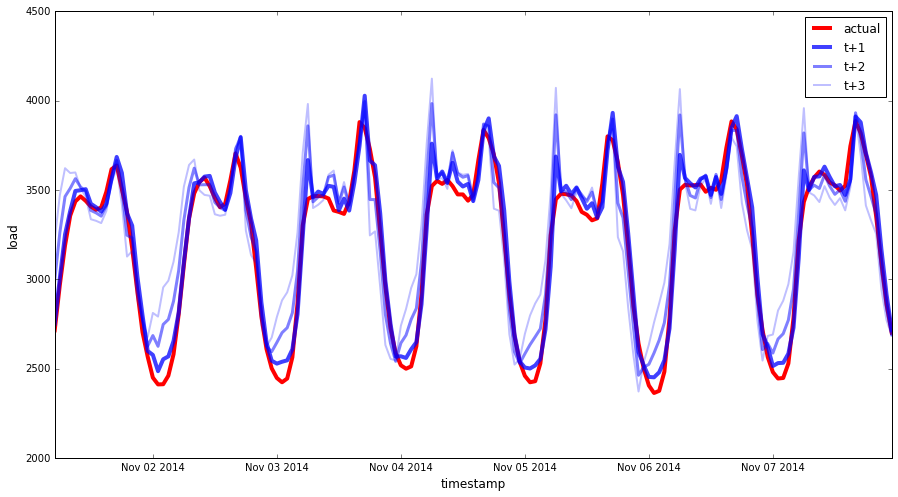

In [23]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()